In [170]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode
import math
%matplotlib inline


In [171]:
matches = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')
match_ids = matches[matches.season >= 2016]['id'].unique()
matches1 = matches[(matches.season >= 2016) & (matches['result']=='normal')]
matches1 = matches1.drop(['player_of_match','venue','umpire1','umpire2','umpire3', 'dl_applied', 'city', 'date', 'result'], axis=1)
matches1.dropna(inplace=True)

In [172]:
def team_correction(row):
    row = row.strip()
    if row == 'Delhi Daredevils':
        return 'Delhi Capitals'
    if row == 'Rising Pune Supergiants':
        return 'Rising Pune Supergiant'
    return row

for col in ['team1', 'team2', 'winner', 'toss_winner']:
    matches1[col] = matches1[col].apply(team_correction)
    

In [173]:
team_1 = 'Kolkata Knight Riders'
team_2 = 'Rajasthan Royals'

In [174]:
delivery = delivery[delivery.match_id.apply(lambda x: True if x in match_ids else False)]
for col in ['batting_team', 'bowling_team']:
    delivery[col] = delivery[col].apply(team_correction)

delivery.fillna(0, inplace=True)
delivery['player_dismissed'] = delivery['player_dismissed'].apply(lambda x: 0 if x==0 else 1)

delivery['batsman_runs'] = delivery['batsman_runs'].apply(lambda x: x-1 if ((x==7) or (x==5)) else x)

In [175]:
def clean(row):
    if row['extra_runs']>= row['batsman_runs']:
        row['extra_runs'] -= row['batsman_runs']
        
    return row

delivery = delivery.apply(clean, axis=1)
delivery['total_runs'] = delivery['extra_runs'] + delivery['batsman_runs']

# Winning Probability of Teams

Text(0.5, 1.0, 'RR Total Runs Score Stats Per Count')

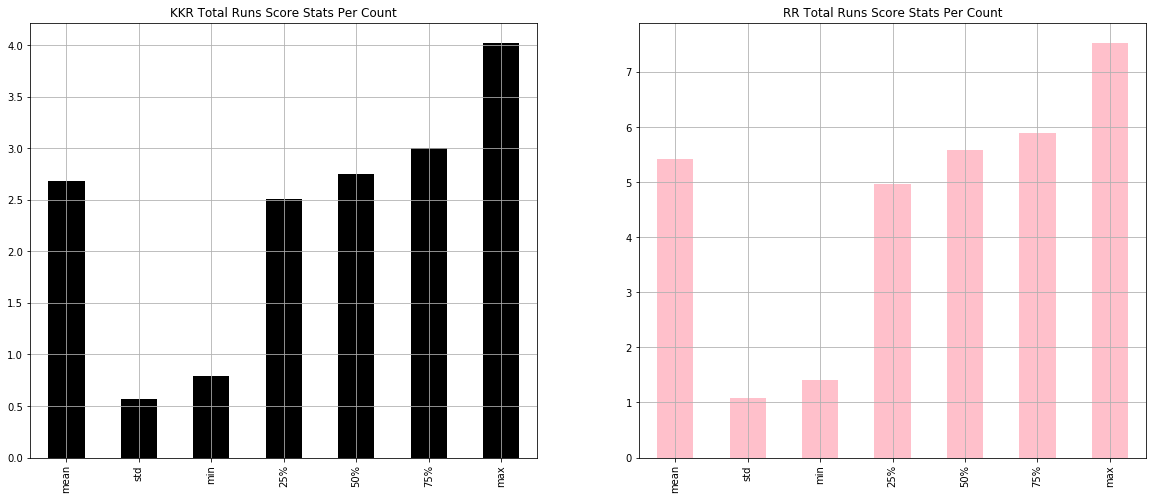

In [192]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
kkr_runs = delivery[delivery['batting_team']==team_1].groupby('match_id').sum()['total_runs']
rr_runs = delivery[delivery['batting_team']==team_2].groupby('match_id').sum()['total_runs']
(kkr_runs.describe()[1:]/kkr_runs.describe()[0]).plot(ax=ax[0], kind='bar', grid=True, color='k')
(rr_runs.describe()[1:]/rr_runs.describe()[0]).plot(ax=ax[1], kind='bar', grid=True, color='pink')
ax[0].set_title("KKR Total Runs Score Stats Per Count")
ax[1].set_title("RR Total Runs Score Stats Per Count")

Text(0.5, 1.0, 'Percentage of Winning')

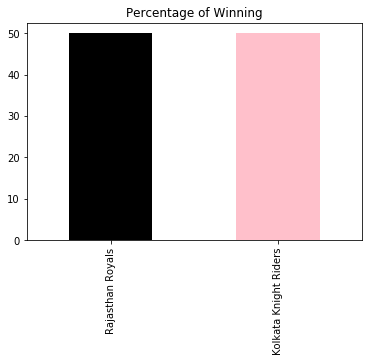

In [191]:
wins = pd.DataFrame(matches1[(matches1['team1'].isin([team_1, team_2])) & (matches1['team2'].isin([team_1, team_2])) & (matches1['season']==2019)]['winner'].value_counts())
wins['Percentage Win Chance'] = (wins['winner']/sum(wins['winner']))*100
wins['Percentage Win Chance'].plot(kind='bar', color=['k', 'pink'])
plt.title('Percentage of Winning')

Since, in previous season the winning chances were same, but the central tendency measures plot show that team scores of RR is better than KKR, so there is high chances of winning for RR compared to KKR.

# Total Wickets Fall

In [178]:
kkr = delivery[(delivery['batting_team']==team_1) & (delivery['player_dismissed']==1)]
rr = delivery[(delivery['batting_team']==team_2) & (delivery['player_dismissed']==1)]

Text(0.5, 1.0, 'RR Wickets against KKR')

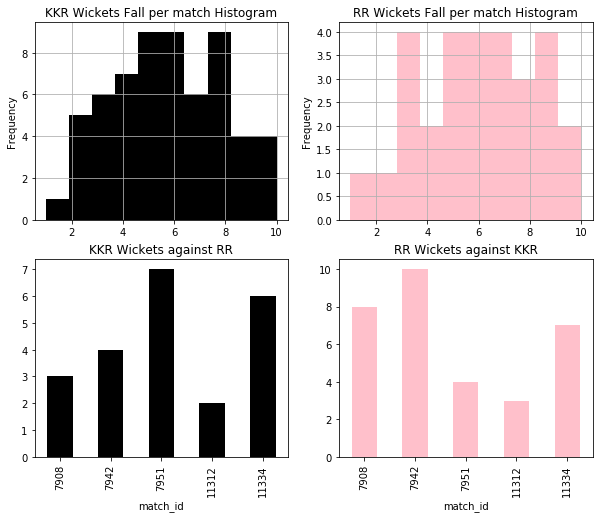

In [179]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))
kkr.groupby('match_id').sum()['player_dismissed'].plot(ax=ax[0, 0], kind='hist', color='k', grid=True)
rr.groupby('match_id').sum()['player_dismissed'].plot(ax=ax[0 ,1], kind='hist', color='pink', grid=True)
kkr[kkr['bowling_team']==team_2].groupby('match_id').sum()['player_dismissed'].plot(ax=ax[1, 0], kind='bar', color='k')
rr[rr['bowling_team']==team_1].groupby('match_id').sum()['player_dismissed'].plot(ax=ax[1, 1], kind='bar', color='pink')
ax[0,0].set_title("KKR Wickets Fall per match Histogram")
ax[0,1].set_title("RR Wickets Fall per match Histogram")
ax[1,0].set_title("KKR Wickets against RR")
ax[1,1].set_title("RR Wickets against KKR")

If you notice the last two graphs which are teams played against each other, if you sum their wickets, 4 out of 5 matches has total 11 wickets lost. Also, the histogram peaks suggests that the total wickets will be around 11. Peaks are also present of towards right side also and is in majority so we will consider higher ranges i.e, 11 to 15 range. 

# Batsman Ratio

In [180]:
def batsman_ratio(batsmen):
    ratios = list()
    for man in batsmen:
        for match_id in delivery[(delivery['batsman']==man)]['match_id'].unique():
            match = delivery[(delivery['match_id']==match_id) & (delivery['batsman']==man)]
            if len(match)>10:
                b_runs = sum(match[(match['batsman_runs'].isin([4,6]))]['batsman_runs'])
                s_runs = sum(match[(match['batsman_runs'].isin([1, 2, 3]))]['batsman_runs'])
                t_runs = sum(match['batsman_runs'])
                ratio = (b_runs-s_runs)/t_runs
                ratios.append([man, ratio])
    return ratios

In [181]:
rr_team = ['BA Stokes', 'RV Uthappa', 'SV Samson', 'SPD Smith', 'JC Buttler', 'R Tewatia', 'J Archer', 'AS Rajpoot', 'S Gopal']
kkr_team = ['S Gill', 'N Rana', 'RA Tripathi', 'KD Karthik', 'SP Narine', 'EJG Morgan', 'PJ Cummins', 'LH Ferguson', 'P Krishna', 'V Chakravarthy']
players = rr_team + kkr_team

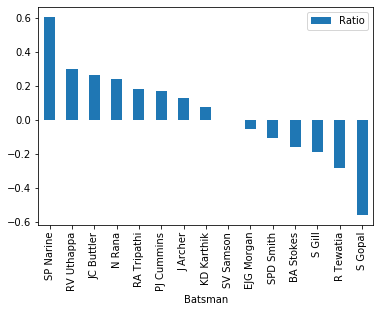

In [182]:
batsmans_performance = pd.DataFrame(data=batsman_ratio(players), columns=['Batsman', 'Ratio'])
batsmans_performance.groupby('Batsman').mean().sort_values(by='Ratio', ascending=False).plot(kind='bar')

# J Archer Economy And Boundaries

In [183]:
def economy_rate(bowler):
    rates = list()
    for match_id in delivery[(delivery['bowler']==bowler)]['match_id'].unique():
        match = delivery[(delivery['bowler']==bowler) & (delivery['match_id']==match_id)]
        boundaries = len(match[(match['total_runs'].isin([4, 5, 6, 7]))])
        t_runs = sum(match['total_runs'])
        balls = len(match)
        rate = t_runs*6/balls
        rates.append([t_runs, balls, boundaries, round(rate, 2)])
    return rates

In [184]:
archer = pd.DataFrame(data=economy_rate('J Archer'), columns=['Runs', 'Balls', 'Boundaries', 'Econ_Rate'])
archer.head()

,Runs,Balls,Boundaries,Econ_Rate
0,23,24,3,5.75
1,27,24,3,6.75
2,31,20,5,9.30
3,43,23,6,11.22
4,32,24,4,8.00


count    21.000000
mean      7.450476
std       2.459851
min       3.780000
25%       5.500000
50%       7.070000
75%       9.300000
max      12.000000
Name: Econ_Rate, dtype: float64


Text(0.5, 1.0, 'Economy Rate of Archer Histogram')

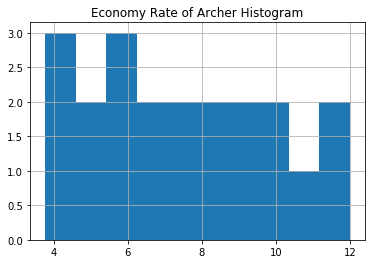

In [185]:
archer['Econ_Rate'].hist()
print(archer['Econ_Rate'].describe())
plt.title("Economy Rate of Archer Histogram")

count    21.000000
mean      3.857143
std       2.220039
min       0.000000
25%       3.000000
50%       3.000000
75%       5.000000
max       8.000000
Name: Boundaries, dtype: float64


Text(0.5, 1.0, 'Boundaries given by Archer per match Histogram')

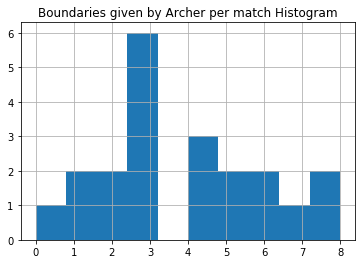

In [186]:
archer['Boundaries'].hist()
print(archer['Boundaries'].describe())
plt.title("Boundaries given by Archer per match Histogram")

# Bowlers with Economy Rate < 8

In [187]:
econ_rate = list()
for bowler in players:
    bowler_rate = [x[-1] for x in economy_rate(bowler)]
    if len(bowler_rate) != 0:
        econ_rate.append([bowler, np.mean(bowler_rate)])

Text(0, 0.5, 'Economy Rates')

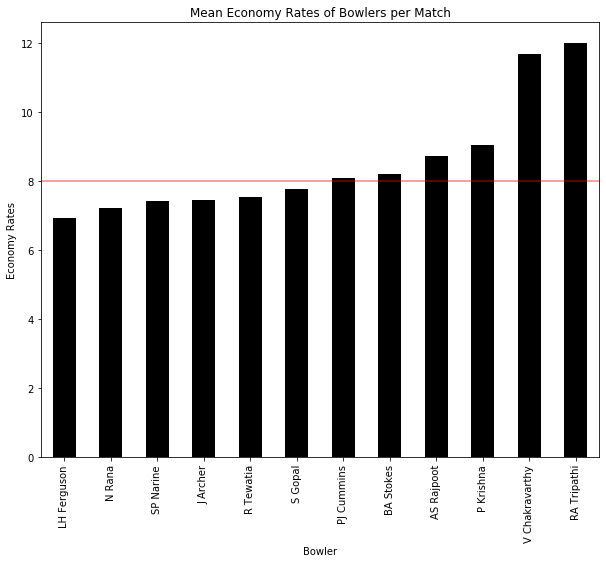

In [188]:
bowler_rates = pd.DataFrame(data=econ_rate, columns=['Bowler', "Rate"]).set_index('Bowler')
bowler_rates.sort_values(by='Rate')['Rate'].plot(kind='bar', color='k', figsize=(10, 8))
plt.axhline(y=8, color='red', alpha=0.5)
plt.title("Mean Economy Rates of Bowlers per Match")
plt.ylabel("Economy Rates")

We will consider the range 4 - 5 because chances of Rana bowling is very less. 

# Summary

1. Central tendency measure of teams score per match and by using winner columns chances of winning were compared.
2. Wicket's fall for both the teams playing against all was calculated and histogram peaks were considered to find the range. Also, the no. of wickets fall for both teams when against each other where calculated and average value was considered. Combining both results, a range was predicted. 
3. A function was created to find batsman ratio per match using batsman_runs column by calculating boundary, single and total runs scored and putting into the formula. Using function, the batsman mean ratio was taken and compared. 
4. A function was created to calculate economy rate using total_runs column and finding runs and balls by sum and len function and also to find out boundaries per match. Using this, Archer's mean economy rate and boundaries were considered.
5. Same function was used to calculate the mean economy rate and compared with 8 to find the number of bowlers. 